# Detecting damaged building exterior using multi-label classification 

Previously we worked on binary classification of damaged and undamaged building and then damaged and undamaged windows. However as there are several major parts of the building exterior we opted for multilabel classification. Mainly we would consider window, door, roof and wall as major building parts and focus on common damage occurs to them.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import os
import pandas as pd
import shutil
from fastai import *
from fastai.vision import *
from fastai.widgets import *
from PIL import Image
import hashlib
#import scipy.misc
#from scipy.misc import imread, imresize, imshow
import time
import numpy as np
from shutil import copyfile
import glob
import matplotlib.pyplot as plt

 We will do it in 3 steps: data preparation, exploratory analysis and damage classification.

In [4]:
import tarfile
tar = tarfile.open("C:/Users/manas/Desktop/fellowship_ai/indoorCVPR_09.tar.gz")
tar.extractall("C:/Users/manas/Desktop/fellowship_ai/")
tar.close()

## Data preparation

To identify damaged building exterior it is important to look into seperate parts of the building and examine if that part is damaged. For our project we have considered 4 major parts of a building: window, door, roof and wall; searched images for each part using appropriate keyword in Google. We accessed urls of all the images using the following javascript codes in the console window of Google image. A .csv file was then created and downloaded with the list of urls in it.

urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);

window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

All the images were downloaded in appropriate folder using download_images funciton. Finally, a total of 6 damage types and a 1 'None' type are created



### Download images

In [13]:
dest = 'C:/Users/manas/Desktop/fellowship_ai/faux-pas/textured_walls/'
filepath = dest + 'urls_textured.csv'

In [7]:
download_images(filepath, dest, max_pics=1000, max_workers=0)

### Removing images that cannot be opened


In [8]:
verify_images(dest, delete=True)

### Converting image type to .JPG


In [7]:
path = 'C:/Users/manas/faux-pas/negative_1/'
for file in os.listdir(path):
    img = Image.open(path + '/' + file)
    filename = file[:8]
    filetype = filename + '.jpg'
    
    img.save(path + '/'+ filetype)

### Merging images from multiple folders and renaming
Images were saved in different folders as obtained from different keyword search. Eventually they were all renamed and moved to one folder.

In [15]:
# To rename multiple files in a directory or folder
# for searched google images using different keywords
  
path = "C:/Users/manas/Desktop/fellowship_ai/faux-pas/textured_walls/"
  
# Function to rename multiple files 
def main(): 
    i = 0
      
    for filename in os.listdir(path): 
        dst ="textured_wall_" + str(i+1) + ".jpg"
        src =path + filename 
        dst = path + dst 
          
        # rename() function will 
        # rename all the files 
        os.rename(src, dst) 
        i += 1
  
# Driver Code 
if __name__ == '__main__': 
      
    # Calling main() function 
    main() 

### Removing duplicates using hashtag

In [30]:
filepath = "C:/Users/manas/faux-pas/lace_doilies/"
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()

In [31]:
os.getcwd()

'C:\\Users\\manas\\faux-pas\\heavy'

In [32]:
os.chdir(r'C:/Users/manas/faux-pas/lace_doilies/')
os.getcwd()

'C:\\Users\\manas\\faux-pas\\lace_doilies'

In [33]:
file_list = os.listdir(filepath)
print(len(file_list))

831


In [34]:
#filepath = 
duplicates = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir(filepath)):
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys: 
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))

In [35]:
# find all duplicates
duplicates

[]

In [15]:
# deleting duplicates from the folder
for index in duplicates:
    os.remove(file_list[index[0]])

### Labeling using fast ai and manual tagging for muli-label classification
This is done in two major steps: 1. clustering the images using platformai, download labelled image names, getting rid of unnecessary files; and 2. tagging labels to individual images.

#### Moving cleaned and clustered files to another folder

In [ ]:
path = "C:/Users/manas/data/building_data/fine_window/"
for i in range(len(df.file_name)):
    if df.labeled_class[i]=='desired':
        filename = path + df.file_name[i]
        destination = "C:/Users/manas/data/building/fine_window_selected/" + df.file_name[i]
        shutil.copyfile(filename, destination)

#### Image labelling

Each image was tagged with labels depending on the features present in the image.Tags ending with '-n' extension represents damaged feature.

In [ ]:
# writing image names to csv file for tagging
files = []
filenames = os.listdir(filepath)
len(filenames)
for i in range(len(filenames)):
    filename = filenames[i][:-4]
    files.append(filename)
#print(files)
df=pd.DataFrame(files)
print(df)
df.to_csv('image_label_door.csv', sep='\t', index=False, header=False)

## Exploratory data analysis


In [3]:
# define damage classes
classes=['cracked wall','cracked window glass','damaged door', 'damaged roof', 'damaged siding','rotted window frame','none']

In [4]:
path = 'C:/Users/manas/data/building_data/'

In [6]:
# Number of images collected per class
for c in classes:
  print("Number of {} images: {}".format(c, str(len(get_image_files(path + c)))))

Number of cracked wall images: 290
Number of cracked window glass images: 305
Number of damaged door images: 294
Number of damaged roof images: 301
Number of damaged siding images: 303
Number of rotted window frame images: 466
Number of none images: 361


Number of images per class are within same range. So we don't need any treatment for class imbalance.

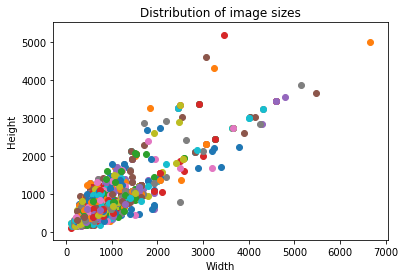

In [7]:
# Scatter plot for image resolution: height vs. width
width_height=[]
for c in classes:
  fnames = get_image_files(path + c)
  for i in fnames:
    im = Image.open(i)
    width, height = im.size
    width_height.append((width, height))    
  
for i in width_height:    
  plt.scatter(i[0],i[1])
  plt.title('Distribution of image sizes')
  plt.xlabel('Width')
  plt.ylabel('Height')

In [8]:
path = "C:/Users/manas/data/building_data/"
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data

ImageDataBunch;

Train: LabelList (1856 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cracked wall,cracked wall,cracked wall,cracked wall,cracked wall
Path: C:\Users\manas\data\building_data;

Valid: LabelList (464 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
none,damaged siding,cracked wall,damaged door,cracked wall
Path: C:\Users\manas\data\building_data;

Test: None

In [10]:
# Data statistics
print("Number of training examples =", len(data.train_ds))
print("Number of validation examples =", len(data.valid_ds))
print("Image data shape =", data.train_ds[0][0].shape)
print("Train Batch size =", data.train_dl.batch_size)
print("Validation Batch size =", data.valid_dl.batch_size)
print("Number of classes =", data.c) 
print("Classes name =", data.classes)

Number of training examples = 1856
Number of validation examples = 464
Image data shape = torch.Size([3, 224, 224])
Train Batch size = 64
Validation Batch size = 64
Number of classes = 7
Classes name = ['cracked wall', 'cracked window glass', 'damaged door', 'damaged roof', 'damaged siding', 'none', 'rotted window frame']


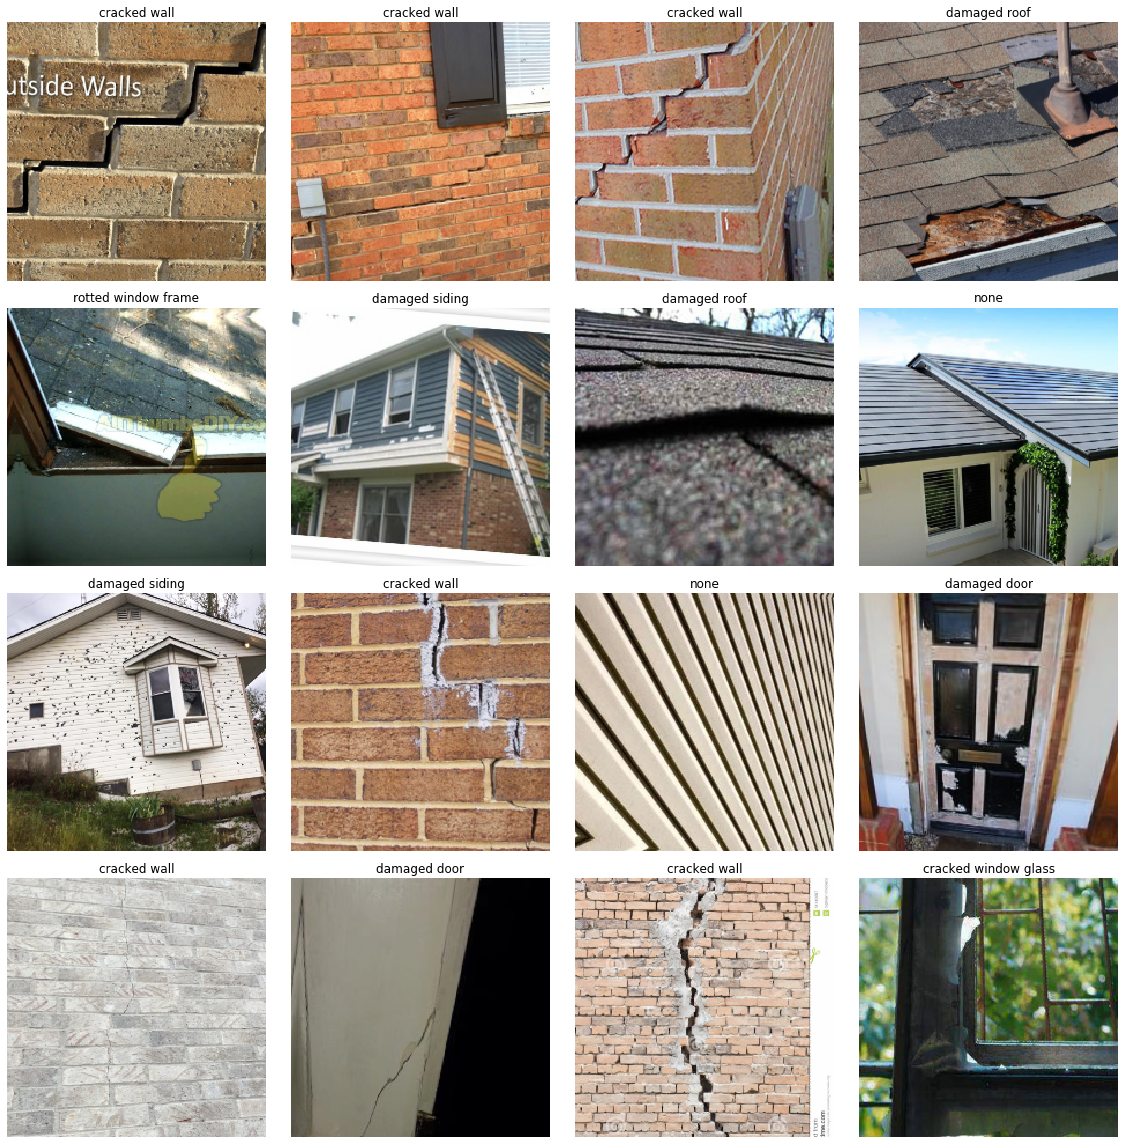

In [12]:
# Visualize Data
data.show_batch(rows=4, figsize=(16,16))

In [13]:
# train dataset stat
train_counts_list = list(map(lambda r: str(r), data.train_ds.y))
dmg_label_trn = pd.DataFrame(train_counts_list, columns=['labels'])
train_counts = dmg_label_trn['labels'].value_counts().reset_index()

In [14]:
# validation dataset stat
valid_counts_list = list(map(lambda r: str(r), data.valid_ds.y))
dmg_label_valid = pd.DataFrame(valid_counts_list, columns=['labels'])
valid_counts = dmg_label_valid['labels'].value_counts().reset_index()

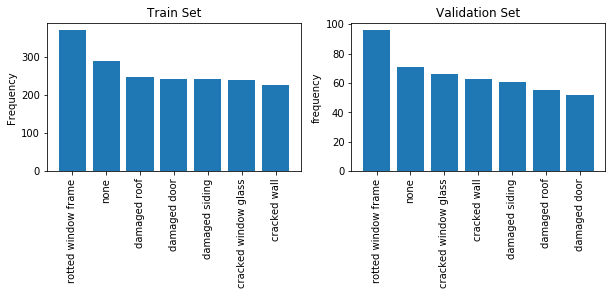

In [15]:
# Frequency distribution: train and test
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))
ax1, ax2 = axes
ax1 = plt.subplot(221)

plt.bar(train_counts['index'], train_counts['labels'])
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Train Set')

ax2 = plt.subplot(222)
plt.bar(valid_counts['index'], valid_counts['labels'])
plt.xticks(rotation=90)
plt.ylabel('frequency')
plt.title('Validation Set')
plt.show()

## Image classification: Baseline model

For baseline model we will use a 34 layer resnet model, default transform, image size 224, default learning rate for first stage training. The performance evaluation metric is accuracy.

In [5]:
path = "C:/Users/manas/data/building_data/"
np.random.seed(42)
bs = 24
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=bs).normalize(imagenet_stats)

In [6]:
learn = cnn_learner(data, models.resnet34, metrics= accuracy)

In [7]:
# First Stage Training with default learning rate
learn.fit_one_cycle(1)

In [8]:
learn.fit_one_cycle(10)

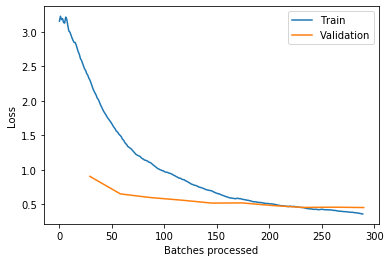

In [11]:
learn.recorder.plot_losses()


In [12]:
learn.save('stage-1')


In [13]:
learn.unfreeze()


In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [ ]:
# Second Stage Training
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-5))

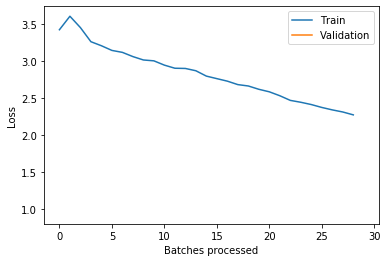

In [7]:
learn.recorder.plot_losses()


In [150]:
learn.save('stage-2')


In [151]:
learn.load('stage-2')


Learner(data=ImageDataBunch;

Train: LabelList (1342 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cracked wall,cracked wall,cracked wall,cracked wall,cracked wall
Path: C:\Users\manas\data\building_data;

Valid: LabelList (335 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rotted window frame,cracked window glass,cracked wall,cracked wall,rotted window frame
Path: C:\Users\manas\data\building_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kerne

## Results

In [152]:
train_interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Train)
valid_interp = ClassificationInterpretation.from_learner(learn)

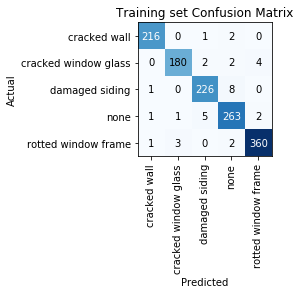

In [153]:
# Plot Training Set Confusion Matrix
train_interp.plot_confusion_matrix(title="Training set Confusion Matrix")

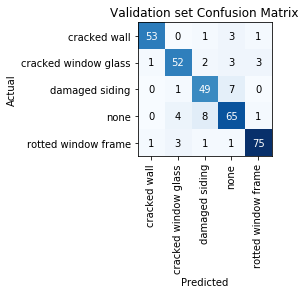

In [154]:
# Plot Validation Set Confusion Matrix
valid_interp.plot_confusion_matrix(title="Validation set Confusion Matrix")


333 misclassified samples over 335 samples in the validation set.


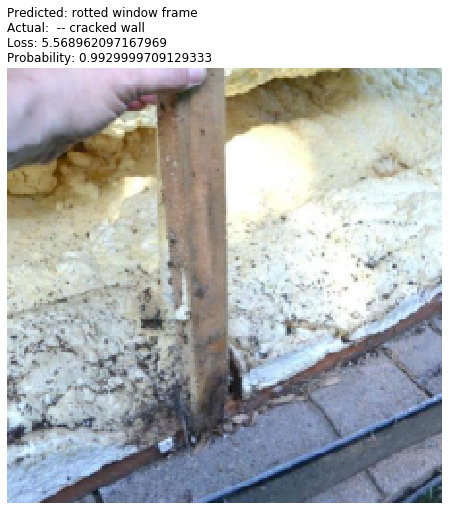

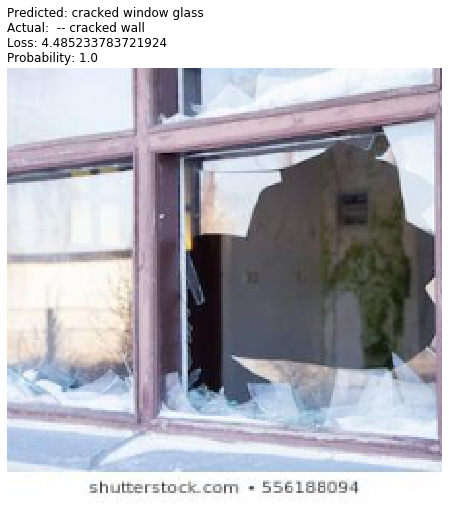

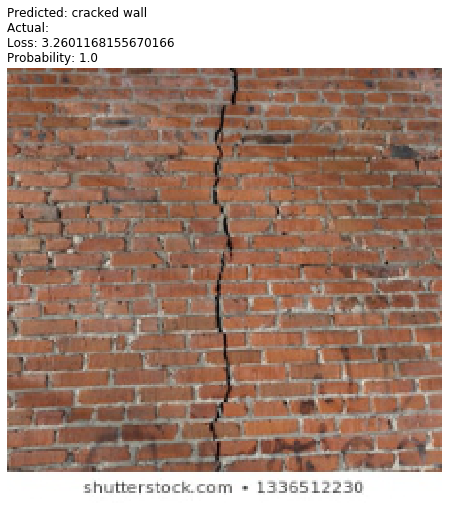

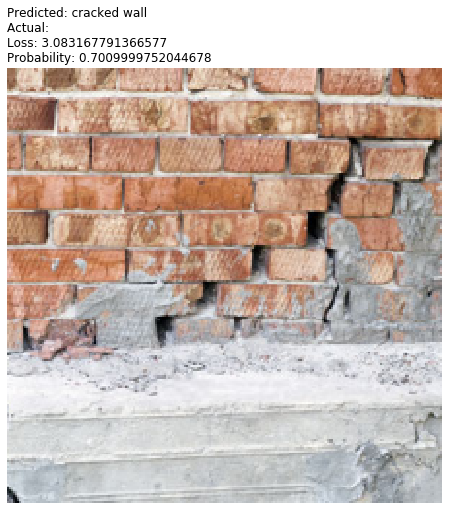

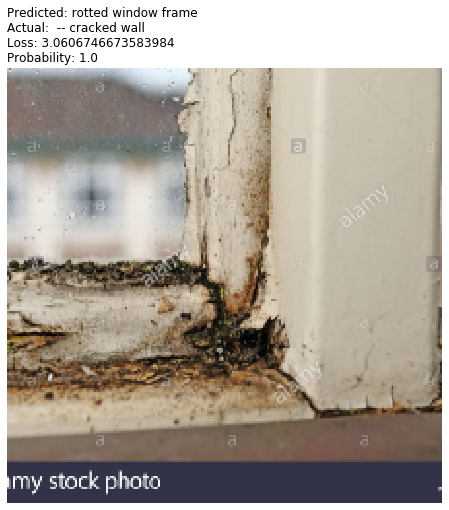

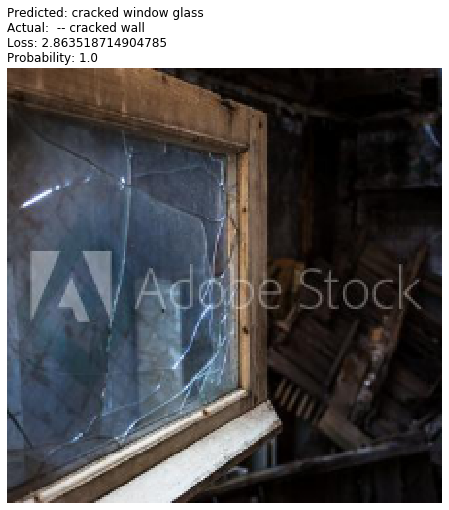

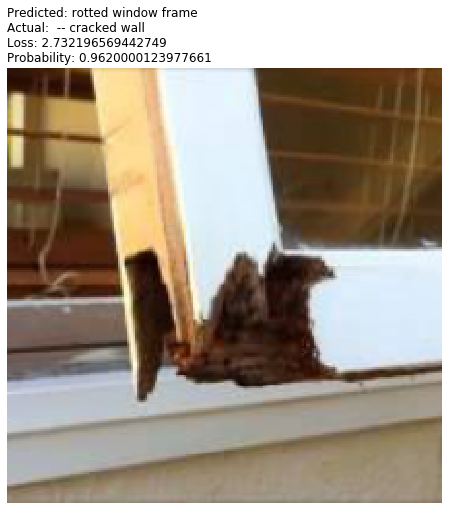

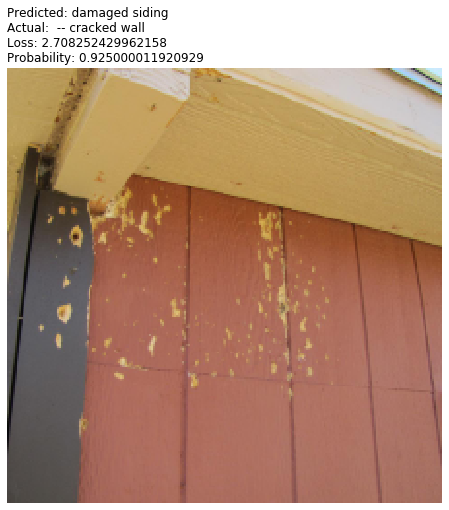

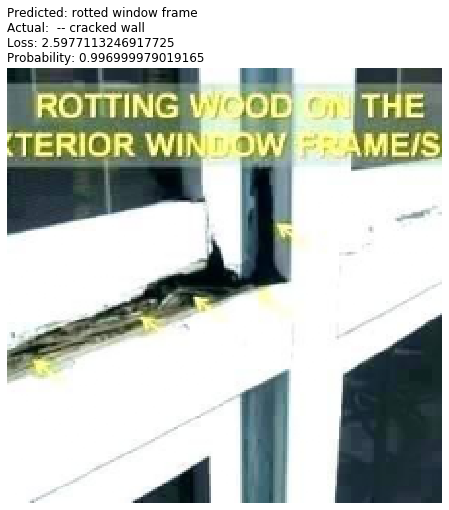

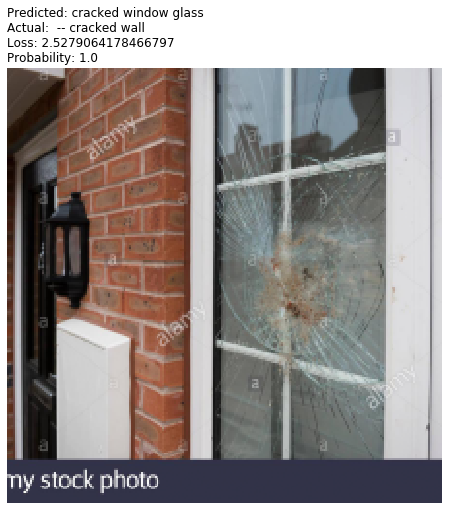

In [157]:
# Plot Top Losses
valid_interp.plot_multi_top_losses(10)

## Advanced model

### Progressive resizing

### hyperparameter tuning

### TTA

### mixup

### More training epoch

We already have tagged each images based on number of features present and whether they are in damaged condition (additional _n). Each tag is separated by space. 

In [32]:
# loading the .csv file with the image names and tags on dataframe
csv_path = 'C:/Users/manas/data/building/'
df = pd.read_csv(csv_path + 'image_label.csv')
df.head()

image_name              tags
0   window_0       window wall
1   window_1  window roof wall
2   window_2       window wall
3   window_3  window roof wall
4   window_4       window wall

In [44]:
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 4804 non-unique tags in all training images
average number of labels per image 1.7766272189349113


In [48]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head(8)

tag     0
5      wall  1181
7    window   851
6    wall_n   719
1      door   630
3      roof   458
8  window_n   361
2    door_n   355
4    roof_n   233

As we can see the numbers of roof, roof_n, door_n, and window_n are relatively low, we have applied oversampling for all those unbalanced classes. Here we have randomly increased the number of observations which are actually copy of the existing samples. With that we have an image dataset size of 3928. 

In [2]:
csv_path = 'C:/Users/manas/data/building/'
df = pd.read_csv(csv_path + 'image_label.csv')
df.head()

image_name              tags  Unnamed: 2
0   window_0       window wall         NaN
1   window_1  window roof wall         NaN
2   window_2       window wall         NaN
3   window_3  window roof wall         NaN
4   window_4       window wall         NaN

In [3]:
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 6075 non-unique tags in all training images
average number of labels per image 1.5469824293353704


In [4]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head(8)

tag     0
5      wall  1227
7    window   853
6    wall_n   717
3      roof   682
4    roof_n   681
8  window_n   646
1      door   635
2    door_n   619

### Customizing data block API

We will use ImageList to put the data in DataBunch in order to create appropriate loss function to handle the multi-classification. The datablock API helps in customizing the DataBunch by isolating the underlying parts of that process in separate blocks, e.g., how to split in train/valid? -> randomly with the default 20% in valid, how to label? -> use the second column of the csv file and split the tags by ' ', etc.

In [5]:
np.random.seed(42)
src = (ImageList.from_csv(csv_path, 'image_label.csv', folder='train_original', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

### Data augmentation

The most important regularization technique in computer vision is data augmentation, which applies small transformation to each data, such as rotation, zoom, translation, brightness, contrast etc. in order to improve the generalization following training. Data augmentation does not alter the image content, but only the pixel values. We will use get_transform to get a set of default transform parameter values which are pretty robust. However we want to rotate the images horizontally only. We will experiment with the max_warp to see how it affect the result as we came across many images taken from many different angles. So it would be interesting to see the change in outcome with this parameter. Finally the databunch is created through transformation and normalization of the dataset.

In [6]:
tfms = get_transforms(do_flip = True, flip_vert=False, max_lighting=0.2, max_zoom=1.05, max_warp=0.2)


Setting the target size another important parameter, especially when the images are of different shapes and sizes. It will ensure that all the images are cropped or padded to the same size so we can then collate them into batches. Here we have set the size as 128. The first training will be done on this smaller size and then we will switch to original size 256. By doing this the training becomes faster and risk of overfitting is reduced.

In [7]:
# conversion to databunch and normalization
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [ ]:
data.show_batch(rows=3, figsize=(7,8))


In [87]:
# number of classes
data.c

8

In [90]:
# name of the classes
data.classes[:]

['door', 'door_n', 'roof', 'roof_n', 'wall', 'wall_n', 'window', 'window_n']

door_n suggests a damaged door. Same applies to other building parts

### Deep learning model: ResNet-50

ResNet is abbreviation for Residual Network which is based on residual learning. In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply understood as subtraction of feature learned from input of that layer. ResNet does this using shortcut connections (directly connecting input of nth layer to some (n+x)th layer. It has proved that training this form of networks is easier than training simple deep convolutional neural networks and also the problem of degrading accuracy with increased number of layers is resolved. ResNet50 is a 50 layer Residual Network.

In [9]:
arch = models.resnet50


Performance metrics chosen are accuracy and fscore for this multilabel classification. If something has a higher probability than the threshold (default = 0.5), we can assume it has that feature. The partial method just creates another method that calls the passed one with a fixed parameter (threshold=0.2 in our case). Next we follow the standard FastAI transfer learning process twice: once for the 128x128px images and then with the 256x256px images. 

In [10]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])


In [11]:
# learning rate optimization
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.74E-02


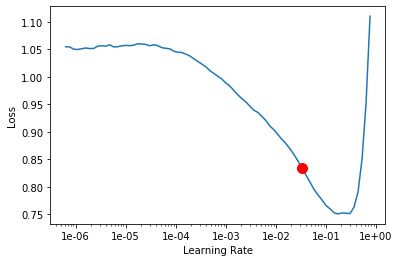

In [13]:
learn.recorder.plot(suggestion=True)

In [14]:
# Chhosing the learning rate towards the mid point of the slope
lr = 0.01 # to be more conservative


Here we train the model using fit_one_cycle for 10 epochs. By fitting one cycle, it would complete one cycle of learning rate, starting low, go up and then coming down. It trained the last layer and left the rest of the model as it was.

In [15]:
learn.fit_one_cycle(10, slice(lr))

We can see how gradually the losses going down. The train_loss and valid_loss is similar suggesting the model is not overfit. As it only trained the top layer we need to unfreeze all the convolutional layers to train them.  

In [16]:
learn.save('stage-1-rn50') # saving last layer


In [17]:
learn.unfreeze() # unfreezing the entire model for training


In [18]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 1.58E-05


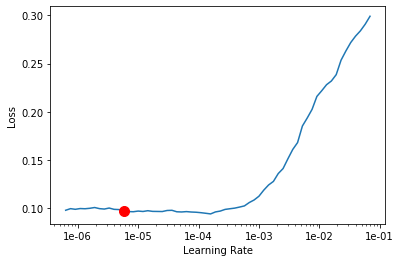

In [20]:
learn.recorder.plot(suggestion=True)


In [21]:
# fit model with differential learning rates
learn.fit_one_cycle(8, slice(1e-5, lr/5)) 

In [22]:
learn.save('stage-2-rn50')


### Training resized dataset

With a sound model now we will a new databunch with image size 256, transform and normalize it as before. The same process is repeated.

In [23]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [24]:
learn.freeze()


In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


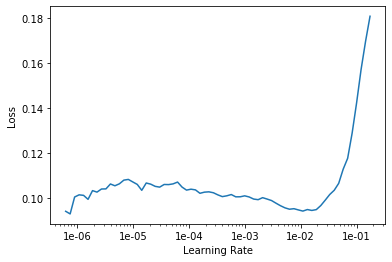

In [26]:
learn.recorder.plot()

In [27]:
lr=1e-2/2


In [28]:
learn.fit_one_cycle(10, slice(lr))


In [29]:
learn.save('stage-1-256-rn50') # saving the weights


In [30]:
learn.unfreeze()


In [32]:
learn.fit_one_cycle(2, slice(1e-5, lr/5))


The accuracy achieved is ~ 95% and F score as 90%.

In [34]:
learn.save('stage-2-256-rn50') # saving weights


In [35]:
learn.export()


In [36]:
learn.load('stage-2-256-rn50');

## Prediction of unseen test data

In [37]:
# test_jpg
test = ImageList.from_folder('C:/Users/manas/data/building/test/')

In [38]:
len(test)


24

In [39]:
path = 'C:/Users/manas/data/building/'
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [40]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]


In [41]:
labelled_preds[:]


['roof',
 'wall window',
 ' door roof wall_n window',
 'wall_n',
 'wall_n',
 'wall_n window_n',
 'wall window',
 'wall window',
 'door_n wall_n',
 'door wall',
 'door window',
 'door wall window',
 'wall window',
 'door wall window',
 'wall window',
 'wall window',
 'wall window',
 'wall window',
 'wall window',
 'wall window_n',
 'wall window_n',
 'wall window_n',
 'wall_n window_n',
 'wall window_n']

In [47]:
%matplotlib inline
image_list = []
path = 'C:/Users/manas/data/building/test/'
for filename in os.listdir(path):
    im=Image.open(path + filename)
    image_list.append(im)

Predicted tags: roof


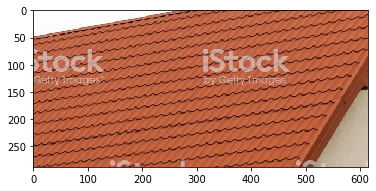

In [49]:
# lets see the some predicted images: window_n means damaged window, wall_n: damaged wall etc.
i = 0
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

Predicted tags: wall window


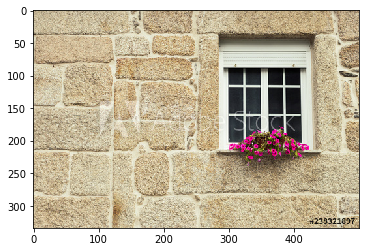

In [62]:
# lets see the predicted images:
i = 1
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

Predicted tags:  door roof wall_n window


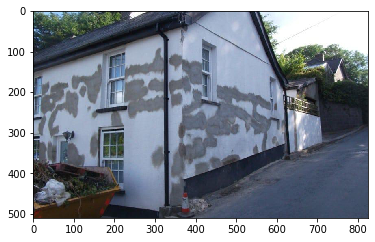

In [63]:
# lets see the predicted images:
i = 2
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

Predicted tags: wall_n


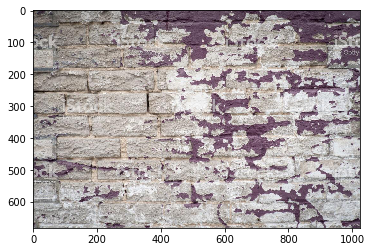

In [65]:
# lets see the predicted images:
i = 4
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

Predicted tags: wall window


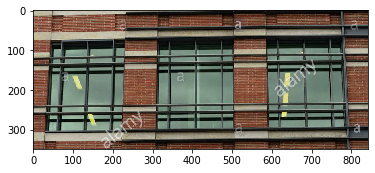

In [67]:
# lets see the predicted images:
i = 6
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

Predicted tags: door wall


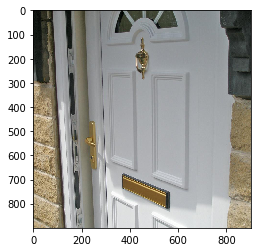

In [70]:
# lets see the predicted images:
i = 9
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

Predicted tags: door wall window


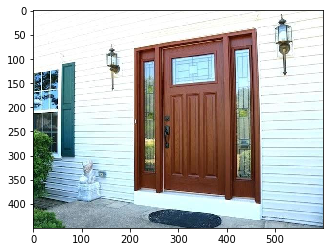

In [72]:
# lets see the predicted images:
i = 11
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

Predicted tags: wall window


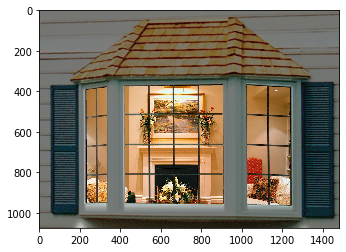

In [77]:
# lets see the predicted images:
i = 16
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

Predicted tags: wall window_n


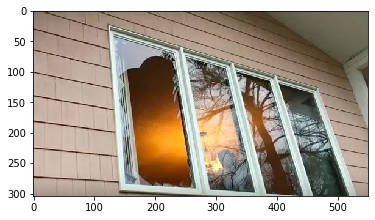

In [80]:
# lets see the predicted images:
i = 19
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

The predictions are pretty accurate!! The model worked really well.

Predicted tags: door window


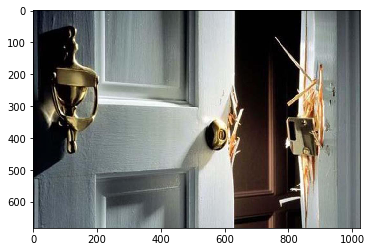

In [103]:
# lets see the predicted images:
i = 10
print('Predicted tags:',labelled_preds[i])
plt.figure()
plt.imshow(image_list[i])
plt.show()

But not so for some cases.